In [1]:
import os
import torch
import numpy as np
import pandas as pd

import pickle
import time
import random

import cv2

from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision


from PIL import Image
from matplotlib import pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# set reandom seeds to allow repeat test comparisons
import random
torch.backends.cudnn.deterministic = True
random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)

In [4]:
! pip install torchinfo
from torchinfo import summary

In [5]:
pickle_dir = './inputs/pickles/v05/'
# load landmarks
with open(pickle_dir + 'resized_lmarks_train_v05.pickle', 'rb') as handle:
    lmarks_train = pickle.load(handle)
with open(pickle_dir + 'resized_lmarks_val_v05.pickle', 'rb') as handle:
    lmarks_val = pickle.load(handle)    
with open(pickle_dir + 'resized_lmarks_test_v05.pickle', 'rb') as handle:
    lmarks_test = pickle.load(handle)
    
# load images
with open(pickle_dir + 'resized_imgs_train_v05.pickle', 'rb') as handle:
    images_train = pickle.load(handle)
with open(pickle_dir + 'resized_imgs_val_v05.pickle', 'rb') as handle:
    images_val = pickle.load(handle)
with open(pickle_dir + 'resized_imgs_test_v05.pickle', 'rb') as handle:
    images_test = pickle.load(handle)

In [6]:
print(len(lmarks_train))
print(len(images_train))

print(len(lmarks_val))
print(len(images_val))

print(len(lmarks_test))
print(len(images_test))

5995
5995
1497
1497
1633
1633


In [7]:
## Load data 
#with open('./data/thr_train/sciebo_imgs_resize128_train.pickle', 'rb') as handle:
#    img_list_train = pickle.load(handle)
#with open('./data/thr_val/sciebo_imgs_resize128_val.pickle', 'rb') as handle:
#    img_list_val = pickle.load(handle)

In [8]:
## Load landmarks 
#with open('./landmarks/sciebo_landmarks_resize128_train.pickle', 'rb') as handle:
#    landmarks_list_train = pickle.load(handle)
#with open('./landmarks/sciebo_landmarks_resize128_val.pickle', 'rb') as handle:
#    landmarks_list_val = pickle.load(handle)

In [9]:
## Load Bentley Test set
#with open('./data/bentley_test/resized_imgs_test_v05.pickle', 'rb') as handle:
#    img_list_test = pickle.load(handle)
#with open('./data/bentley_test/resized_lmarks_test_v05.pickle', 'rb') as handle:
#    landmarks_list_test = pickle.load(handle)

In [10]:
def vis_images(img_list, landmarks_list, first_img, nrows, ncols):
    fig, ax = plt.subplots(nrows, ncols, figsize=(ncols+5, nrows+5)) # create figure
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]); # turn off all axes ticks
    idx_plt = 0
    for row in range(nrows):
        for col in range(ncols):
            img = img_list[idx_plt+first_img].copy()
            landmark_tuples = landmarks_list[idx_plt+first_img]
            for n in range(0,68):
                try:
                    x=landmark_tuples[n][0]
                    y=landmark_tuples[n][1]
                    cv2.circle(img, (x, y), 1, (255, 0, 0), -1)
                except:
                    pass
            if nrows == 1 or ncols == 1:
                ax[idx_plt].imshow(img)
            else:
                ax[row][col].imshow(img)
            idx_plt+= 1
            
    plt.tight_layout()
    plt.show()

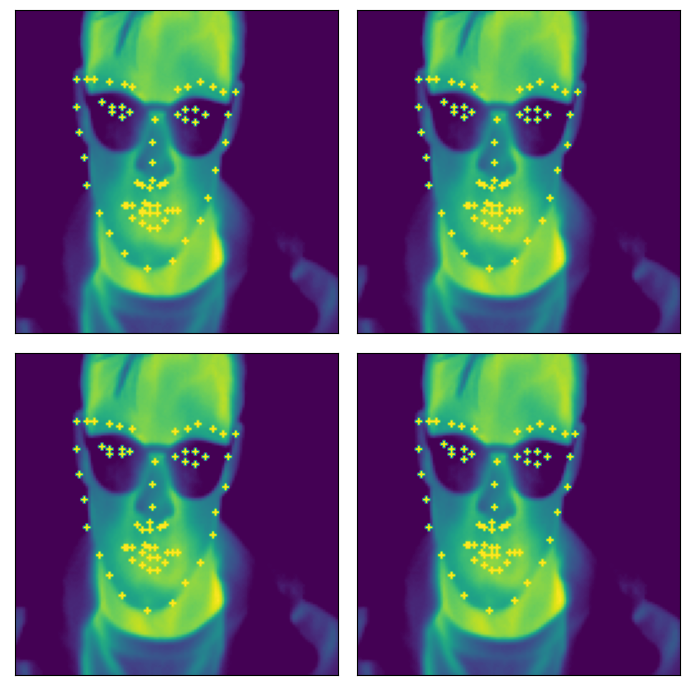

In [11]:
vis_images(images_train, lmarks_train, 4200, 2, 2)

## Check test data

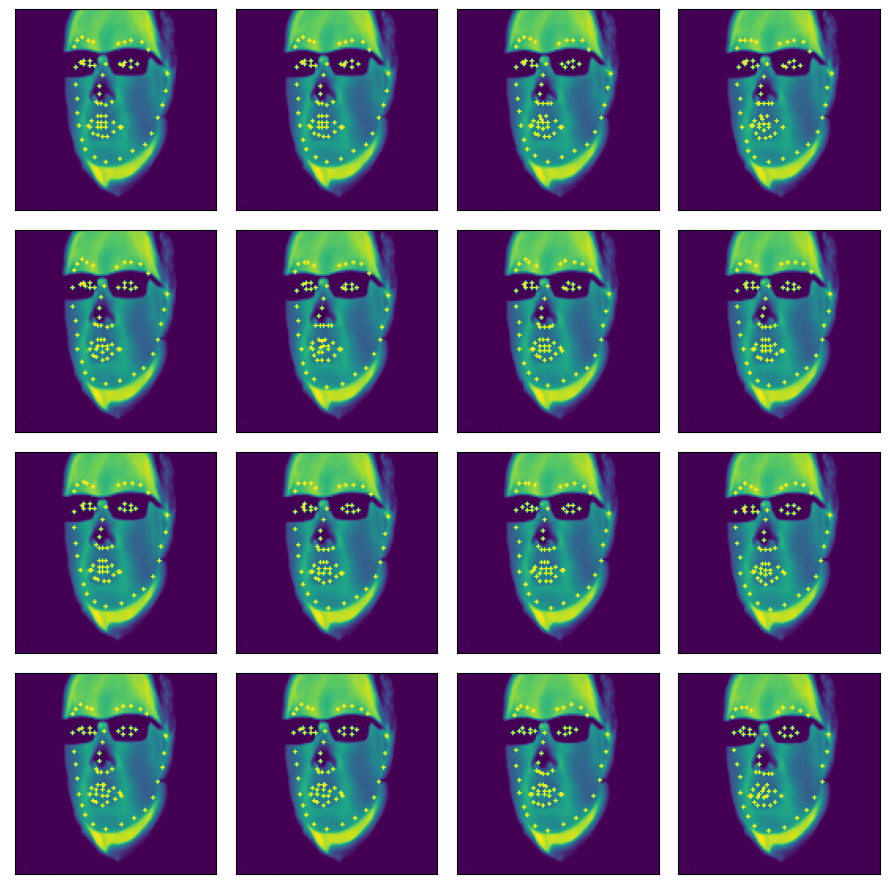

In [12]:
vis_images(images_test, lmarks_test, 100, 4, 4)

In [13]:
def simple_scale(array):
    '''simple scale to put amplitudes between 0 and 1. Better scaling based on 
    min/max/std dev for several images may help - need to see Bentley data'''
    return (array - array.min()) / (array.max() - array.min())

def data_prep(img_list):
    # scale images to between 0 and 1
    scaled_images = [simple_scale(x) for x in img_list]
    # move the channel axis from last to first for each image
    prep_list = torch.tensor([np.expand_dims(x, axis=0) for x in scaled_images])
    return prep_list

In [14]:
train_tensors = data_prep(images_train)
val_tensors = data_prep(images_val)
test_tensors = data_prep(images_test)

In [15]:
print(train_tensors.shape)
print(val_tensors.shape)
print(test_tensors.shape)

torch.Size([5995, 1, 128, 128])
torch.Size([1497, 1, 128, 128])
torch.Size([1633, 1, 128, 128])


Define Unet

In [16]:
class conv_block(nn.Module):
    """
    Convolution Block 
    """
    def __init__(self, in_ch, out_ch):
        super(conv_block, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))

    def forward(self, x):

        x = self.conv(x)
        return x


class up_conv(nn.Module):
    """
    Up Convolution Block
    """
    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x

In [17]:
class UNet_small(nn.Module):
    """
    UNet - Basic Implementation
    Paper : https://arxiv.org/abs/1505.04597
    """
    def __init__(self, in_ch=1, out_ch=1):
        super(UNet_small, self).__init__()

        n1 = 64
        filters = [n1, n1 * 2, n1 * 4, n1 * 8]
        
        self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = conv_block(in_ch, filters[0])
        self.Conv2 = conv_block(filters[0], filters[1])
        self.Conv3 = conv_block(filters[1], filters[2])
        self.Conv4 = conv_block(filters[2], filters[3])

        self.Up4 = up_conv(filters[3], filters[2])
        self.Up_conv4 = conv_block(filters[3], filters[2])

        self.Up3 = up_conv(filters[2], filters[1])
        self.Up_conv3 = conv_block(filters[2], filters[1])

        self.Up2 = up_conv(filters[1], filters[0])
        self.Up_conv2 = conv_block(filters[1], filters[0])

        self.Conv = nn.Conv2d(filters[0], out_ch, kernel_size=1, stride=1, padding=0)

       # self.active = torch.nn.Sigmoid()

    def forward(self, x):

        e1 = self.Conv1(x)

        e2 = self.Maxpool1(e1)
        e2 = self.Conv2(e2)

        e3 = self.Maxpool2(e2)
        e3 = self.Conv3(e3)

        e4 = self.Maxpool3(e3)
        e4 = self.Conv4(e4)

        d4 = self.Up4(e4)
        d4 = torch.cat((e3, d4), dim=1)

        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((e2, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((e1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        out = self.Conv(d2)
        # add sigmoid to keep values between 0 and 1 - sm
        out = torch.sigmoid(out)

        #d1 = self.active(out)

        return out

## Reload pretrained models and add MLP layers

In [18]:
pretrained_list = []
optimiser_list = []
for i in range (5):
    pretrained_unet = UNet_small()
    pretrained_optimiser_unet = torch.optim.Adam(pretrained_unet.parameters(), lr=0.0001)

    pretrained_model_path = './models/Bentley_Basic_UNet_v05' + str(i) + '_init.pt'

    checkpoint = torch.load(pretrained_model_path)
    pretrained_unet.load_state_dict(checkpoint['model_state_dict'])
    pretrained_optimiser_unet.load_state_dict(checkpoint['optimizer_state_dict'])
    pretrained_list.append(pretrained_unet)
    optimiser_list.append(pretrained_optimiser_unet)

In [19]:
# pretrained = torchvision.models.alexnet(pretrained=True)
class UNet_MLP(nn.Module):
    def __init__(self, pretrained_unet):
        super(UNet_MLP, self).__init__()
        self.pretrained = pretrained_unet
        self.my_new_layers = nn.Sequential(nn.Flatten(),
                                           nn.Linear(16384, 1024),
                                           nn.Sigmoid(),
                                           nn.Linear(1024, 136))
    
    def forward(self, x):
        x = self.pretrained(x)
        x = self.my_new_layers(x)
        return x

UNet_MLP_model = UNet_MLP(pretrained_unet=pretrained_list[0])
UNet_MLP_model

UNet_MLP(
  (pretrained): UNet_small(
    (Maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Conv1): conv_block(
      (conv): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (Conv2): conv_block(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stat

Train Network

In [20]:
# Functions for the training and evaluation phase of the model. This is after model setup
def model_train(model, train_loader, optimiser, loss_fn, loss_train, device = torch.device("cpu")):
    
    model.train() # set into training mode
    loss_epoch = 0
    
    for batch in train_loader:        
        model.zero_grad() # initialise gradients to zero
        images, gtruth = batch # set images from batch
        images = images.to(device)
        gtruth = gtruth.to(device)
        outputs = model(images.float()) # forward pass: compute predicted outputs by passing inputs through model
        loss = loss_fn(outputs, gtruth.float()) # calculate the loss
        loss.backward() # backpropagate regularised loss
        optimiser.step() # single update of weights
#         loss_epoch += loss.item()*images.size(0) # update running training loss
        loss_epoch += loss.item() # update running training loss

    loss_train.append(loss_epoch/len(train_loader))
        
        
def model_eval(model, val_loader, loss_fn, loss_val, device = torch.device("cpu")):
    
    model.eval() # set to evaluation mode.     
    loss_total = 0
    
    with torch.no_grad(): # no backpropagation/ weight updates!
        for batch in val_loader:
            images, gtruth = batch
            images = images.to(device)
            gtruth = gtruth.to(device)
            preds = model(images.float())
            loss = loss_fn(preds, gtruth.float())
#             loss_total += loss.item()*images.size(0) # update running training loss
            loss_total += loss.item() # update running training loss            
        
    loss_val.append(loss_total/len(val_loader))

# MLP

In [21]:
def Landmark1DTensor(landmarks_list):
    out_list = []
    """convert list of list of tuples to list of lists"""
    for lms in landmarks_list:
        # convert list of tuples to single list
        out = [item for t in lms for item in t]
        # append to list for each image
        out_list.append(out)
    return torch.tensor(out_list)

In [29]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [23]:
# generate gtruth 1d tensor
mlp_gtruth_train = Landmark1DTensor(lmarks_train)
# generate unet_mlp data loader
train_ds_mlp = torch.utils.data.TensorDataset(train_tensors, mlp_gtruth_train)
train_dl_mlp = DataLoader(train_ds_mlp, batch_size=16, shuffle=True)
print(mlp_gtruth_train.shape)
print(train_tensors.shape)

torch.Size([5995, 136])
torch.Size([5995, 1, 128, 128])


In [24]:
# generate gtruth 1d tensor
mlp_gtruth_val = Landmark1DTensor(lmarks_val)
# generate unet_mlp data loader
val_ds_mlp = torch.utils.data.TensorDataset(val_tensors, mlp_gtruth_val)
val_dl_mlp = DataLoader(val_ds_mlp, batch_size=16, shuffle=True)
print(mlp_gtruth_val.shape)
print(val_tensors.shape)

torch.Size([1497, 136])
torch.Size([1497, 1, 128, 128])


In [25]:
# generate gtruth 1d tensor
mlp_gtruth_test = Landmark1DTensor(lmarks_test)
# generate unet_mlp data loader
test_ds_mlp = torch.utils.data.TensorDataset(test_tensors, mlp_gtruth_test)
test_dl_mlp = DataLoader(test_ds_mlp, batch_size=16, shuffle=True)
print(mlp_gtruth_test.shape)
print(test_tensors.shape)

torch.Size([1633, 136])
torch.Size([1633, 1, 128, 128])


In [30]:
results_MLP  = {"test_no": [], "train_loss": [], "val_loss": []}
test_no = 0

for i in range(1):

    print('run:', i)

    # set reandom seeds to allow repeat test comparisons
    torch.backends.cudnn.deterministic = True
    random.seed(i)
    torch.manual_seed(i)
    torch.cuda.manual_seed(i)
    np.random.seed(i)

    model_mlp = UNet_MLP(pretrained_unet=pretrained_list[i])
    model_mlp.to(device)
    train_loader_mlp = train_dl_mlp
    val_loader_mlp = val_dl_mlp

    # specify loss function
    loss_fn_mlp = torch.nn.MSELoss()
    # specify optimiser
    optimiser = torch.optim.Adam(model_mlp.parameters(), lr=0.0001)

    # number of epochs to train the model
    n_epochs = 200

    loss_train = []
    loss_val = []

    start_time = time.time()

    for epoch in range(1, n_epochs+1):
        model_train(model_mlp, train_loader_mlp, optimiser, loss_fn_mlp, loss_train, device = device)
        model_eval(model_mlp, val_loader_mlp, loss_fn_mlp, loss_val, device = device)

        if epoch%10 == 0:
            print(f'Epoch: {epoch}|Loss (train): {loss_train[-1]:.3f}| Loss (val): {loss_val[-1]:.3f}')

    results_MLP["test_no"].append(test_no)
    results_MLP["train_loss"].append(loss_train)
    results_MLP["val_loss"].append(loss_val)
    test_no += 1

    model_save_path = './models/Bentley_Basic_UNet_MLP_v05_' + str(i) + '_init.pt'
    torch.save({'model_state_dict': model_mlp.state_dict(), 
            'optimizer_state_dict': optimiser.state_dict(),
           }, model_save_path)
    
    print("runtime:", time.time() - start_time)
    
    gc.collect()
    torch.cuda.empty_cache()

run: 0
Epoch: 10|Loss (train): 7.542| Loss (val): 24.487
Epoch: 20|Loss (train): 0.798| Loss (val): 23.730
Epoch: 30|Loss (train): 0.402| Loss (val): 21.945
Epoch: 40|Loss (train): 0.324| Loss (val): 21.139
Epoch: 50|Loss (train): 0.295| Loss (val): 20.082
Epoch: 60|Loss (train): 0.279| Loss (val): 19.284
Epoch: 70|Loss (train): 0.263| Loss (val): 19.116
Epoch: 80|Loss (train): 0.251| Loss (val): 19.009
Epoch: 90|Loss (train): 0.242| Loss (val): 18.281
Epoch: 100|Loss (train): 0.233| Loss (val): 19.520
Epoch: 110|Loss (train): 0.226| Loss (val): 18.329
Epoch: 120|Loss (train): 0.219| Loss (val): 18.362
Epoch: 130|Loss (train): 0.214| Loss (val): 18.067
Epoch: 140|Loss (train): 0.210| Loss (val): 18.176
Epoch: 150|Loss (train): 0.205| Loss (val): 18.757
Epoch: 160|Loss (train): 0.200| Loss (val): 18.538
Epoch: 170|Loss (train): 0.196| Loss (val): 18.203
Epoch: 180|Loss (train): 0.192| Loss (val): 17.813
Epoch: 190|Loss (train): 0.188| Loss (val): 18.849
Epoch: 200|Loss (train): 0.183| L

In [31]:
# Save loss curve data
with open('./loss_curves/Bentley_Basic_Unet_MLP_v05.pickle', 'wb') as handle:
    pickle.dump(results_MLP, handle)

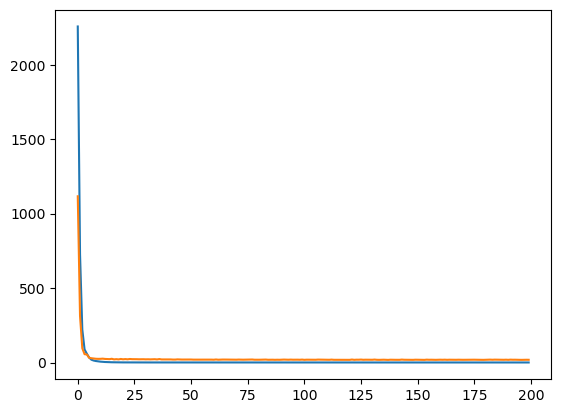

In [32]:
plt.plot(loss_train)
plt.plot(loss_val)
plt.show()

In [33]:
def model_predict(model, data_loader, device = torch.device("cpu")):
    model.to(device)
    model.eval() # set to evaluation mode. 

    images_list = []
    gtruth_list = []
    output_list = []    
    
    with torch.no_grad(): # no backpropagation/ weight updates!
        for batch in data_loader:
            images, gtruth = batch
            images = images.to(device)
            gtruth = gtruth.to(device)
            preds = model(images.float())
            # print(preds.shape)
            images_list.append(images)
            gtruth_list.append(gtruth)
            output_list.append(preds)

    images_tensor = torch.cat(images_list)
    gtruth_tensor = torch.cat(gtruth_list)
    output_tensor = torch.cat(output_list)

    return images_tensor, gtruth_tensor, output_tensor

In [34]:
train_images, train_gtruth, train_output = model_predict(model_mlp, train_dl_mlp)

In [35]:
val_images, val_gtruth, val_output = model_predict(model_mlp, val_dl_mlp)

In [36]:
test_images, test_gtruth, test_output = model_predict(model_mlp, test_dl_mlp)

In [44]:
def MLP_output_plot(images, gtruth, output, img, nrows, ncols):
    fig, ax = plt.subplots(nrows = nrows, ncols=ncols, figsize=(ncols+8, nrows+8))
    idx_plt = 0
    for row in range(nrows):
        for col in range(ncols):
            image_lm = images[img+idx_plt].detach().cpu().numpy()
            gtruth_lm = gtruth[img+idx_plt].detach().cpu().numpy()
            output_lm = output[img+idx_plt].detach().cpu().numpy()

            image_lm = image_lm.squeeze()
            image = np.zeros((128, 128, 3), dtype=np.uint8)
            image[:,:,0] = image_lm*255
            image[:,:,1] = image_lm*255
            image[:,:,2] = image_lm*255

            lmarks_ou = []
            for i, val in enumerate(output_lm):
                if (i % 2) == 0:
                    x = output_lm[i]
                    y = output_lm[i+1]  
                    lmarks_ou.append([x,y])
            l_map_ou = np.zeros([128,128])
            for l in lmarks_ou:
                j = int(l[0]) -1
                i = int(l[1]) -1
                if i > 127:
                    i = 127
                if j > 127:
                    j = 127
                l_map_ou[i,j] = 1
                # print(i,j)
                image = cv2.circle(image, (j, i), 1, (255, 0, 0), -1)

            # print('  ')
            
            lmarks_gt = []
            for i, val in enumerate(gtruth_lm):
                if (i % 2) == 0:
                    x = gtruth_lm[i]
                    y = gtruth_lm[i+1]  
                    lmarks_gt.append([x,y])   
            l_map_gt = np.zeros([128,128])
            for l in lmarks_gt:
                j = l[0] - 1
                i = l[1] - 1
                if i > 127:
                    i = 127
                if j > 127:
                    j = 127
                l_map_gt[i,j] = 1
                image = cv2.circle(image, (j, i), 1, (0, 255, 0), -1)

            ax[row, col].imshow(image)

            idx_plt+= 1

    plt.tight_layout()
    plt.show() 

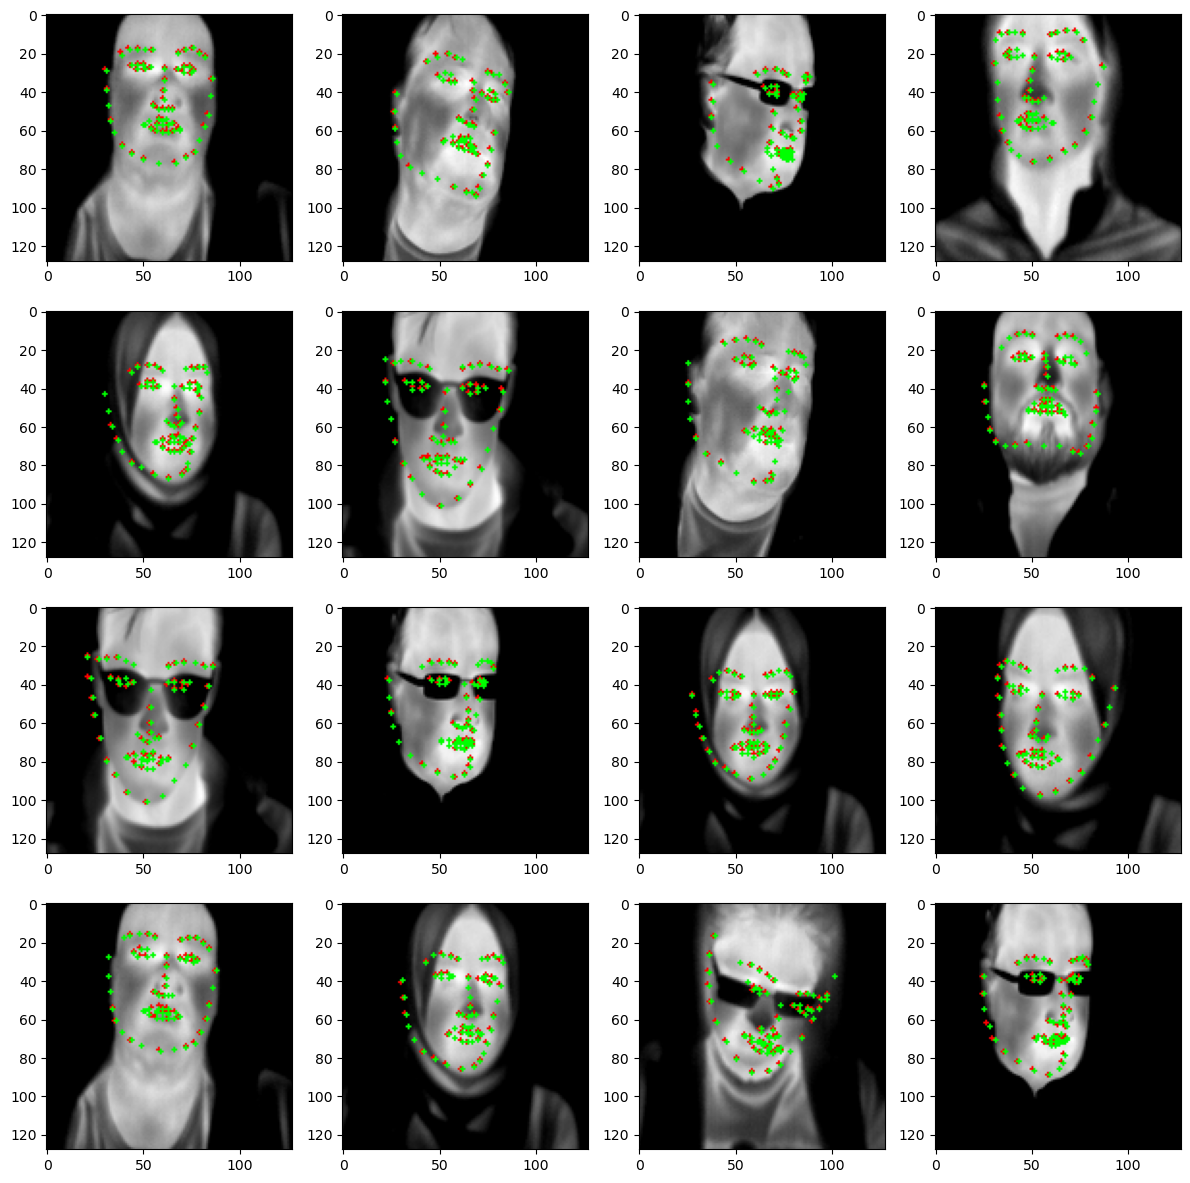

In [45]:
MLP_output_plot(train_images, train_gtruth, train_output, 1000, 4, 4)

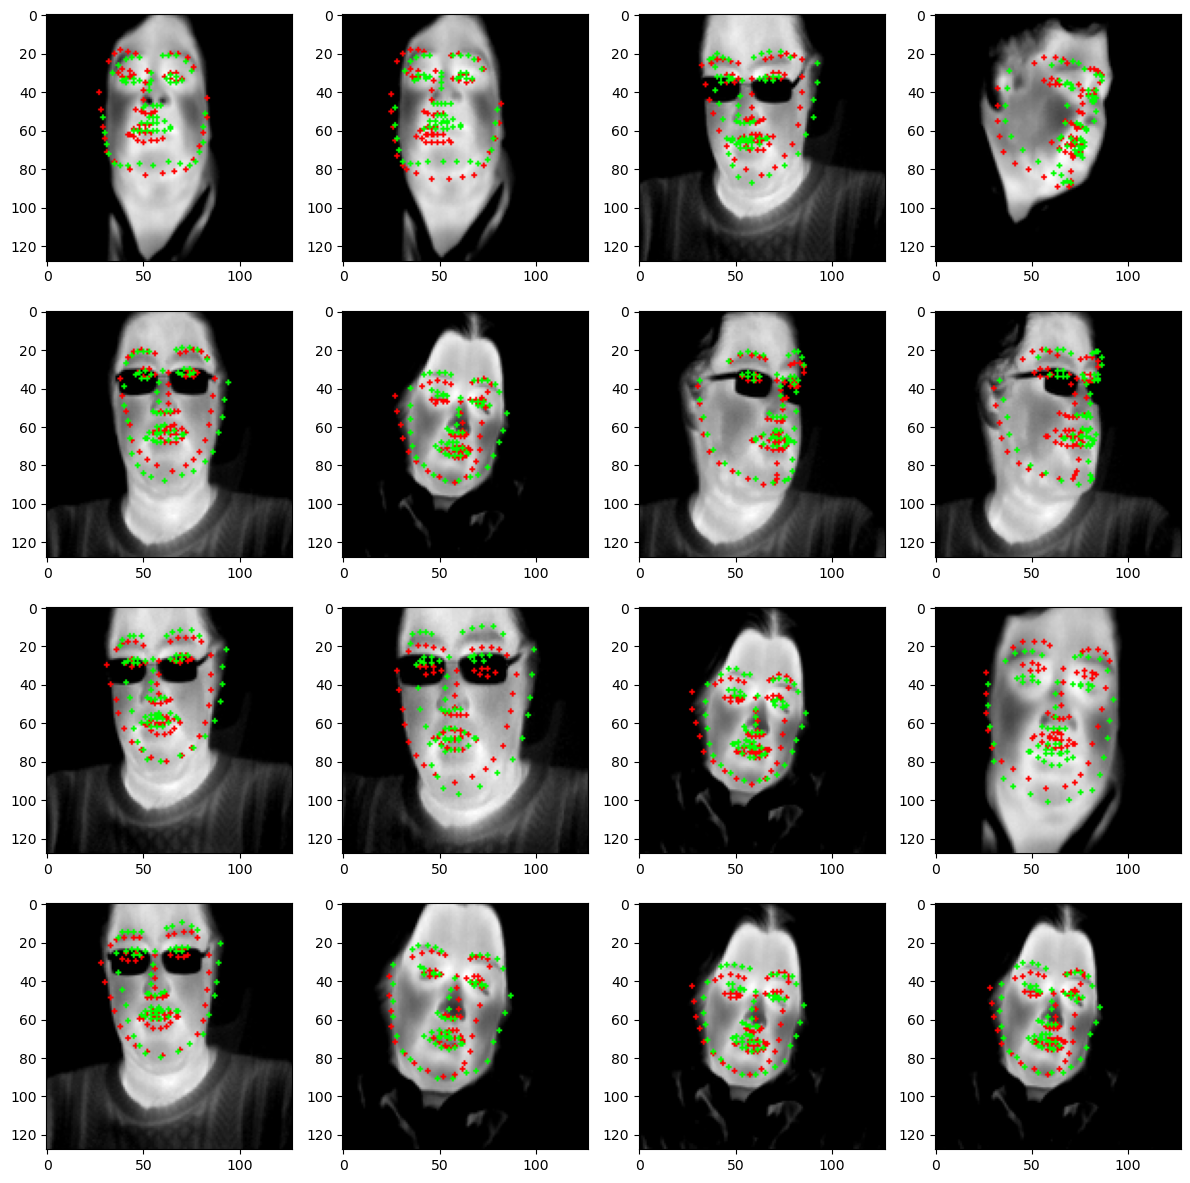

In [46]:
MLP_output_plot(val_images, val_gtruth, val_output, 50, 4, 4)

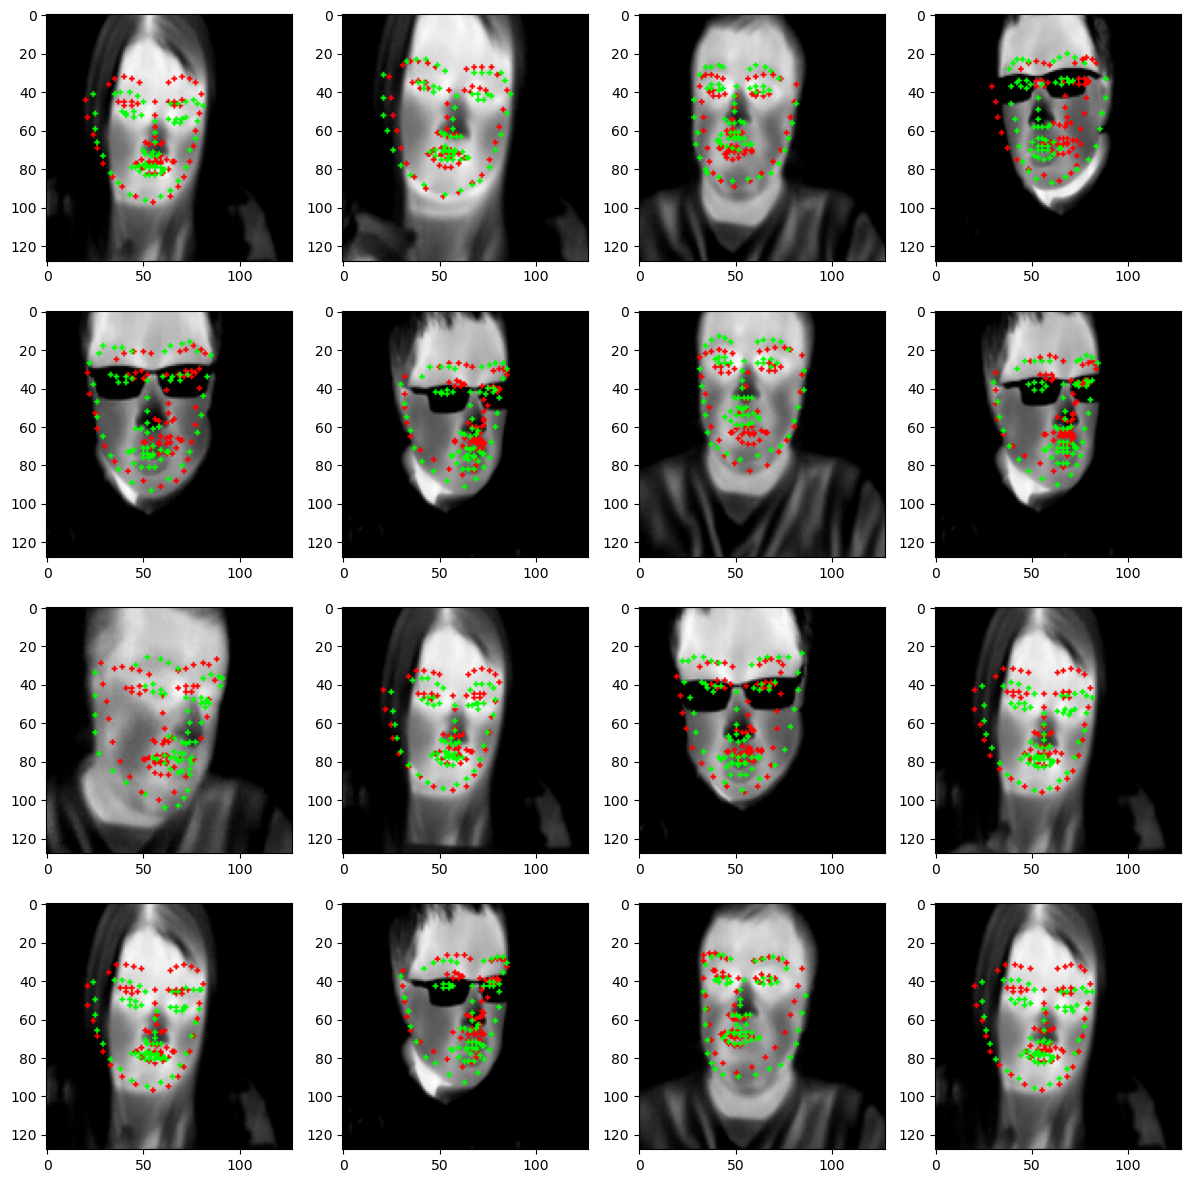

In [47]:
MLP_output_plot(test_images, test_gtruth, test_output, 0, 4, 4)

# Calculate Errors

In [48]:
def Tensor2Landmarks(lm_tensor):
    lm_np = lm_tensor.detach().cpu().numpy()
    # print(lm_np)
    lm_list = []
    for i in range(68):
        lm = [lm_np[i*2],lm_np[(i*2)+1]]
        lm_list.append(lm)
    return lm_list

In [49]:
def landmark_error(gtruth_lms, pred_lms):
    K = len(gtruth_lms)
    # print('K:', K)
    leye_gt = gtruth_lms[36:42]
    reye_gt = gtruth_lms[42:48]
    leye_gt_centre = np.array(leye_gt).mean(axis=0)
    reye_gt_centre = np.array(reye_gt).mean(axis=0)
    Di = np.linalg.norm(leye_gt_centre-reye_gt_centre)
    # print('Di:', Di)
    dist_sum = 0
    for i, lms in enumerate(gtruth_lms):
        gt = np.array(gtruth_lms[i])
        pred = np.array(pred_lms[i])
        dist = np.linalg.norm(gt-pred)
        dist_sum += dist
    #     print(i, dist)
    #     print(lmarks_1[i], lmarks_2[i])

    lm_err = dist_sum/(K*Di)
    # print('lm_err', lm_err)
    return lm_err    

In [50]:
def landmark_error_all(val_gtruth, val_output):
    lm_err_list = []
    for i in range(len(val_gtruth)):
        gtruth = Tensor2Landmarks(val_gtruth[i])
        output = Tensor2Landmarks(val_output[i])
        lm_err = landmark_error(gtruth, output)
        lm_err_list.append(lm_err)
    return lm_err_list

In [51]:
lm_err_train_list = landmark_error_all(train_gtruth, train_output)
np.mean(lm_err_train_list)

0.022594285456848825

In [52]:
lm_err_val_list = landmark_error_all(val_gtruth, val_output)
np.mean(lm_err_val_list)

0.24532253344309823

In [53]:
lm_err_test_list = landmark_error_all(test_gtruth, test_output)
np.mean(lm_err_test_list)

0.2569028196535358